In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install https://github.com/Antonio-Ionaton/GradientCorrection/tarball/main
#!pip uninstall gradientcorrection

     - 2.6 kB 9.0 MB/s
  Created wheel for gradientcorrection: filename=gradientcorrection-0.1-py3-none-any.whl size=3715 sha256=caf932907dfc55cfcac07b4b75d989813c02b4e75099024935ef7bfd8ab23195
  Stored in directory: /tmp/pip-ephem-wheel-cache-3wfnmakz/wheels/03/4c/0a/9516d8fa386ed9a21d1aa50e8cc5b1f6d6f576195897b24409
Successfully built gradientcorrection


In [ ]:
import gradientcorrection
from gradientcorrection import layers, utils, metrics, helper, explain, model_zoo, geomath

#### import python modules

In [ ]:
import os, h5py
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from tensorflow import keras

#### load data

In [ ]:
experiment ='SRF'
filename = experiment + '_200.h5'

data_path = 'drive/My Drive/'
results_path = make_directory('drive/My Drive/', 'results_invivo(initializations)')  #utils.make_directory('../results', 'task3')
params_path = make_directory(results_path, 'model_params') 

file_path = os.path.join(data_path, filename)
dataset = h5py.File(file_path, 'r') 
x_train = np.array(dataset['x_train']).astype(np.float32).transpose([0,2,1])  
y_train = np.array(dataset['y_train']).astype(np.float32)
x_valid = np.array(dataset['x_valid']).astype(np.float32).transpose([0,2,1])
y_valid = np.array(dataset['y_valid']).astype(np.float32)
x_test = np.array(dataset['x_test']).astype(np.float32).transpose([0,2,1])
y_test = np.array(dataset['y_test']).astype(np.float32)
print(dataset.keys())  
print(x_train.shape)
print(x_test.shape)

<KeysViewHDF5 ['x_test', 'x_train', 'x_valid', 'y_test', 'y_train', 'y_valid']>
(7854, 200, 4)


In [ ]:
!pip install https://github.com/p-koo/tfomics/tarball/master
import tfomics

  Using cached https://github.com/p-koo/tfomics/tarball/master


In [ ]:
from tfomics.fit import MonitorMetrics, LRDecay, EarlyStopping, progress_bar

@tf.function
def saliency_map(X, model):
  with tf.GradientTape() as tape:
    tape.watch(X)
    outputs = model(X, training=True)[:,0]
  return tape.gradient(outputs, X)

@tf.function
def calculate_angles(saliency_score):
  orthogonal_residual = tf.reduce_sum(saliency_score, axis=-1)
  L2_norm = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(saliency_score), axis=-1))
  sine = 1/2 * orthogonal_residual / L2_norm 
  sine = tf.math.asin(sine) * tf.constant(180/3.1416) 
  return sine


class CustomTrainer():
  """Custom training loop from scratch"""

  def __init__(self, model, loss, optimizer, metrics, reg_factor=1e-4):
    self.model = model
    self.loss = loss
    self.optimizer = optimizer
    self.reg_factor = tf.constant(reg_factor)

    # metrics to monitor
    metric_names = []
    for metric in metrics:
        metric_names.append(metric)

    # class to help monitor metrics
    self.metrics = {}
    self.metrics['train'] = MonitorMetrics(metric_names, 'train')
    self.metrics['valid'] = MonitorMetrics(metric_names, 'valid')
    self.metrics['test'] = MonitorMetrics(metric_names, 'test')

  @tf.function
  def train_step(self, x, y, metrics):
    """training step for a mini-batch"""
    
    with tf.GradientTape() as tape:
      preds = self.model(x, training=True)
      loss = self.loss(y, preds)
      saliency = saliency_map(x, self.model)
      sine = calculate_angles(saliency)
      l2_norm = tf.math.sqrt(tf.reduce_sum(tf.math.square(sine), axis=-1, keepdims=True))
      total_loss = loss + self.reg_factor*tf.reduce_mean(l2_norm)
    gradients = tape.gradient(total_loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))
    metrics.update_running_metrics(y, preds)
    return loss

  @tf.function
  def test_step(self, x, y, metrics, training=False):
    """test step for a mini-batch"""
    preds = self.model(x, training=training)
    loss = self.loss(y, preds)
    metrics.update_running_metrics(y, preds)
    return loss
    

  def train_epoch(self, trainset, batch_size=128, shuffle=True, verbose=False, store=True):
    """train over all mini-batches and keep track of metrics"""

    # prepare data
    if shuffle:
      trainset.shuffle(buffer_size=batch_size)
    batch_dataset = trainset.batch(batch_size)
    num_batches = len(list(batch_dataset))

    # train loop over all mini-batches 
    start_time = time.time()
    running_loss = 0
    for i, (x, y) in enumerate(batch_dataset):      
      loss_batch = self.train_step(x, y, self.metrics['train'])
      self.metrics['train'].running_loss.append(loss_batch)
      running_loss += loss_batch
      progress_bar(i+1, num_batches, start_time, bar_length=30, loss=running_loss/(i+1))

    # store training metrics
    if store:
      if verbose:
        self.metrics['train'].update_print()
      else:
        self.metrics['train'].update()


  def evaluate(self, name, dataset, batch_size=128, verbose=True, training=False):
    """Evaluate model in mini-batches"""
    batch_dataset = dataset.batch(batch_size)
    num_batches = len(list(batch_dataset))
    for i, (x, y) in enumerate(batch_dataset):   
      loss_batch = self.test_step(x, y, self.metrics[name], training)
      self.metrics[name].running_loss.append(loss_batch)

    # store evaluation metrics
    if verbose:
      self.metrics[name].update_print()
    else:
      self.metrics[name].update()   
    

  def predict(self, x, batch_size=128):
    """Get predictions of model"""
    pred = self.model.predict(x, batch_size=batch_size)  
    return pred


  def set_early_stopping(self, patience=10, metric='loss', criterion=None):
    """set up early stopping"""
    self.early_stopping = EarlyStopping(patience=patience, metric=metric, criterion=criterion)
    

  def check_early_stopping(self, name='valid'):
    """check status of early stopping"""
    return self.early_stopping.status(self.metrics[name].get(self.early_stopping.metric)[-1])


  def set_lr_decay(self, decay_rate, patience, metric='loss', criterion=None):
    """set up learning rate decay"""
    self.lr_decay = LRDecay(optimizer=self.optimizer, decay_rate=decay_rate, 
                            patience=patience, metric=metric, criterion=criterion)

  def check_lr_decay(self, name='valid'):
    """check status and update learning rate decay"""
    self.lr_decay.check(self.metrics[name].get(self.lr_decay.metric)[-1])


  def get_metrics(self, name, metrics=None):
    """return a dictionary of metrics stored throughout training"""
    if metrics is None:
      metrics = {}
    metrics[name+'_loss'] = self.metrics[name].loss
    for metric_name in self.metrics[name].metric_names:
      metrics[name+'_'+metric_name] = self.metrics[name].get(metric_name)
    return metrics


  def set_learning_rate(self, learning_rate):
    """short-cut to set the learning rate"""
    self.optimizer.learning_rate.assign(learning_rate)



def fit_attr_prior(model, loss, optimizer, x_train, y_train, validation_data, verbose=True,  
                  metrics=['auroc', 'aupr'], num_epochs=100, batch_size=128, shuffle=True, 
                  reg_factor=1e-4, es_patience=10, es_metric='auroc', es_criterion='max',
                  lr_decay=0.3, lr_patience=3, lr_metric='auroc', lr_criterion='max'):


  # create tensorflow dataset
  trainset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  validset = tf.data.Dataset.from_tensor_slices(validation_data)

  # create trainer class
  trainer = CustomTrainer(model, loss, optimizer, metrics, reg_factor)
  trainer.set_lr_decay(decay_rate=lr_decay, patience=lr_patience, metric=lr_metric, criterion=lr_criterion)
  trainer.set_early_stopping(patience=es_patience, metric=es_metric, criterion=es_criterion)

  # train model
  for epoch in range(num_epochs):  
    sys.stdout.write("\rEpoch %d \n"%(epoch+1))
    
    # train over epoch
    trainer.train_epoch(trainset, batch_size=batch_size, shuffle=shuffle, verbose=False)

    # validation performance
    trainer.evaluate('valid', validset, batch_size=batch_size, verbose=verbose)

    # check learning rate decay
    trainer.check_lr_decay('valid')
   
    # check early stopping
    if trainer.check_early_stopping('valid'):
      print("Patience ran out... Early stopping.")
      break
  
  # compile history
  history = trainer.get_metrics('train')
  history = trainer.get_metrics('valid', history)

  return history, trainer


In [ ]:
## Initialization training.
kernel_size=[3, 5, 7, 9,11,13,15,17,19,21]

sigmas = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]

results = []
sines = []
saliency_scores_cummulative = []

for sigma in sigmas:
  print ('sigma=',sigma)
  model = cnn_dist_init_model(first_layer_kernel_size=kernel_size[5], activation='relu', sigma=sigma)  #cnn_local_init_model

  # set up optimizer and metrics
  auroc = keras.metrics.AUC(curve='ROC', name='auroc')
  aupr = keras.metrics.AUC(curve='PR', name='aupr')
  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  loss = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0)
  model.compile(optimizer=optimizer, loss=loss, metrics=[auroc, aupr])


  # early stopping callback
  es_callback = keras.callbacks.EarlyStopping(monitor='val_auroc', 
                                              patience=10, 
                                              verbose=1, 
                                              mode='max', 
                                              restore_best_weights=True)
  # reduce learning rate callback
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_auroc', 
                                                  factor=0.2,
                                                  patience=4, 
                                                  min_lr=1e-7,
                                                  mode='max',
                                                  verbose=1) 

  # train model
  history = model.fit(x_train, y_train, 
                      epochs=100,
                      batch_size=100, 
                      shuffle=True,
                      validation_data=(x_valid, y_valid), 
                      callbacks=[es_callback, reduce_lr])

  # test model 
  vals = model.evaluate(x_test, y_test)

  # get positive label sequences and sequence model
  pos_index = np.where(y_test[:,0] == 1)[0]   

  num_analyze = len(pos_index)
  X = x_test[pos_index[:num_analyze]]
  #X_model = model_test[pos_index[:num_analyze]]

  # instantiate explainer class
  explainer = tfomics.explain.Explainer(model, class_index=0)
  #saliency_scores = explainer.saliency_maps(X)
  saliency_scores = np.array(explain.saliency(model, X, class_index=0, layer=-2, batch_size=256))
  saliency_scores_cummulative.append(saliency_scores)
  #sine = geomath.calculate_angles(saliency_scores)
 

  results.append(vals[1])
  #sines.append(sine)

In [ ]:
sines = geomath.calculate_angles(saliency_scores_cummulative) 

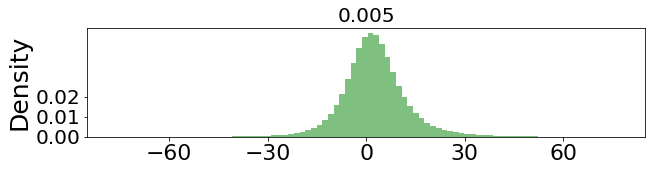

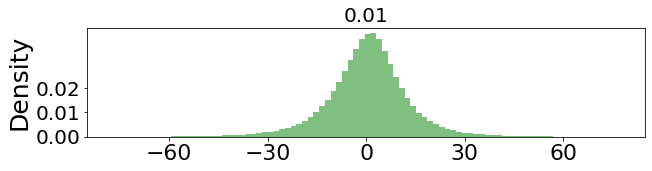

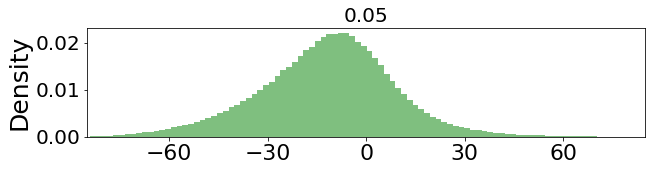

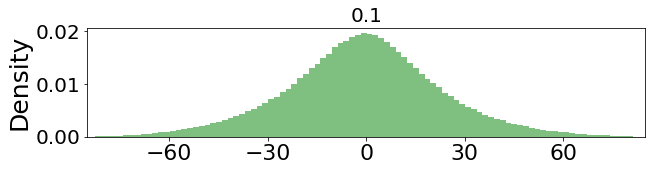

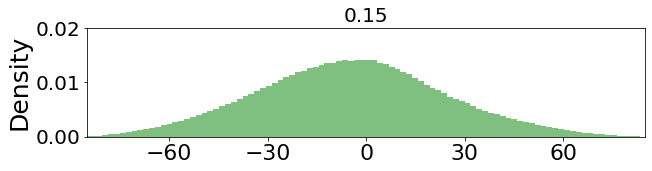

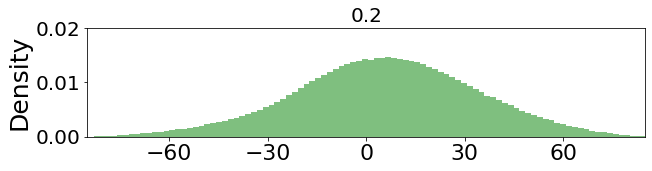

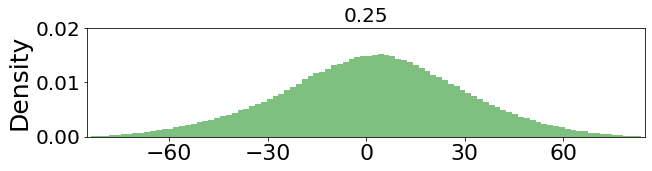

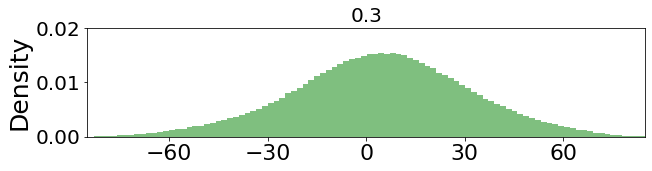

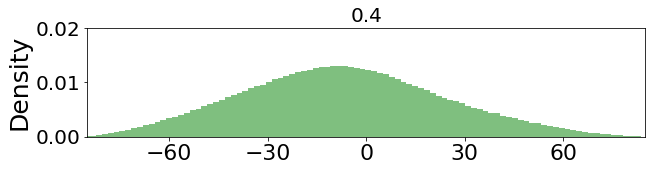

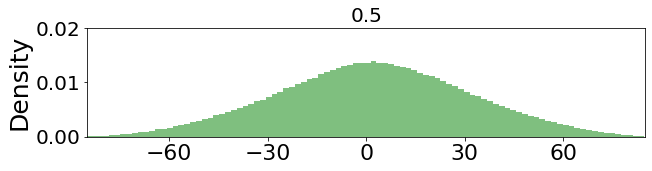

In [ ]:
import matplotlib.pyplot as plt
for i, sigma in enumerate(sigmas):
  plt.figure(figsize=(10,2))
  plt.hist(np.reshape(sines[i],[-1]), 100, density=True, alpha=0.5, color='g')
  plt.ylabel('Density', fontsize=25)
  plt.xticks([-60, -30, 0, 30, 60], fontsize=22)
  #plt.tick_params(axis='x',  which='both', bottom=False,  top=False, labelbottom=False) 
  plt.yticks(ticks=[0.0, 0.01, 0.02], fontsize=20)
  plt.xlim([-85, 85])
  plt.title(sigma, fontsize=20)

Text(0.5, 0, 'Std of initialization')

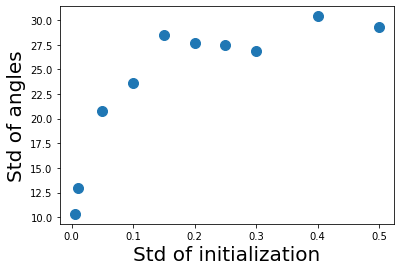

In [ ]:
vals = []
for sine in sines:
  vals.append(np.nanstd(np.reshape(sine,[-1])))

plt.figure()
plt.scatter(sigmas, vals, 100)
plt.ylabel('Std of angles', fontsize=20)
plt.xlabel('Std of initialization', fontsize=20)

In [ ]:
print(sigmas)
print(results)
print(vals)

[0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
[0.87853235, 0.86987066, 0.87644774, 0.88843817, 0.8774749, 0.8737774, 0.88338083, 0.87866706, 0.87332964, 0.8845378]
[10.333018, 13.00296, 20.735357, 23.632174, 28.456738, 27.703129, 27.518112, 26.90787, 30.387438, 29.25747]
